# Bayesian Hidden Markov Models
This tutorial illustrates training Bayesian [Hidden Markov Models](https://en.wikipedia.org/wiki/Hidden_Markov_model) (HMM) using Turing. The main goals are learning the transition matrix, emission parameter, and hidden states. For a more rigorous academic overview on Hidden Markov Models, see [An introduction to Hidden Markov Models and Bayesian Networks](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) (Ghahramani, 2001).

Let's load the libraries we'll need. We also set a random seed (for reproducibility) and the automatic differentiation backend to forward mode (more [here](http://turing.ml/docs/autodiff/) on why this is useful).

In [56]:
# Load libraries.
using Turing, Plots, Random

# Turn off progress monitor.
Turing.setprogress!(false);

# Set a random seed and use the forward_diff AD mode.
Random.seed!(1234);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/dvd/.julia/packages/Turing/Gntg0/src/Turing.jl:30
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/dvd/.julia/packages/AdvancedVI/J4yH6/src/AdvancedVI.jl:15


## Simple State Detection

In this example, we'll use something where the states and emission parameters are straightforward.

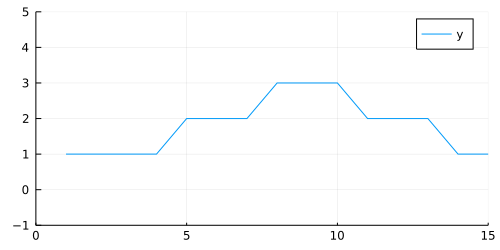

In [84]:
# Define the emission parameter.
y = [ 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 1.0, 1.0 ];
N = length(y);  K = 3;

# Plot the data we just made.
plot(y, xlim = (0,15), ylim = (-1,5), size = (500, 250), label="y")

We can see that we have three states, one for each height of the plot (1, 2, 3). This height is also our emission parameter, so state one produces a value of one, state two produces a value of two, and so on.

Ultimately, we would like to understand three major parameters:

1. The transition matrix. This is a matrix that assigns a probability of switching from one state to any other state, including the state that we are already in.
2. The emission matrix, which describes a typical value emitted by some state. In the plot above, the emission parameter for state one is simply one.
3. The state sequence is our understanding of what state we were actually in when we observed some data. This is very important in more sophisticated HMM models, where the emission value does not equal our state.

With this in mind, let's set up our model. We are going to use some of our knowledge as modelers to provide additional information about our system. This takes the form of the prior on our emission parameter.

$$
m_i \sim Normal(i, 0.5), \space m = \{1,2,3\}
$$

Simply put, this says that we expect state one to emit values in a Normally distributed manner, where the mean of each state's emissions is that state's value. The variance of 0.5 helps the model converge more quickly — consider the case where we have a variance of 1 or 2. In this case, the likelihood of observing a 2 when we are in state 1 is actually quite high, as it is within a standard deviation of the true emission value. Applying the prior that we are likely to be tightly centered around the mean prevents our model from being too confused about the state that is generating our observations.

The priors on our transition matrix are noninformative, using `T[i] ~ Dirichlet(ones(K)/K)`. The Dirichlet prior used in this way assumes that the state is likely to change to any other state with equal probability. As we'll see, this transition matrix prior will be overwritten as we observe data.

In [58]:
# Turing model definition.
@model BayesHmm(y, K) = begin
    # Get observation length.
    N = length(y)

    # State sequence.
    s = tzeros(Int, N)

    # Emission matrix.
    m = Vector(undef, K)

    # Transition matrix.
    T = Vector{Vector}(undef, K)

    # Assign distributions to each element
    # of the transition matrix and the
    # emission matrix.
    for i = 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ Normal(i, 0.5)
    end

    # Observe each point of the input.
    s[1] ~ Categorical(K)
    y[1] ~ Normal(m[s[1]], 0.1)

    for i = 2:N
        s[i] ~ Categorical(vec(T[s[i-1]]))
        y[i] ~ Normal(m[s[i]], 0.1)
    end
end;

We will use a combination of two samplers ([HMC](http://turing.ml/docs/library/#Turing.HMC) and [Particle Gibbs](http://turing.ml/docs/library/#Turing.PG)) by passing them to the [Gibbs](http://turing.ml/docs/library/#Turing.Gibbs) sampler. The Gibbs sampler allows for compositional inference, where we can utilize different samplers on different parameters.

In this case, we use HMC for `m` and `T`, representing the emission and transition matrices respectively. We use the Particle Gibbs sampler for `s`, the state sequence. You may wonder why it is that we are not assigning `s` to the HMC sampler, and why it is that we need compositional Gibbs sampling at all.

The parameter `s` is not a continuous variable. It is a vector of **integers**, and thus Hamiltonian methods like HMC and [NUTS](http://turing.ml/docs/library/#-turingnuts--type) won't work correctly. Gibbs allows us to apply the right tools to the best effect. If you are a particularly advanced user interested in higher performance, you may benefit from setting up your Gibbs sampler to use [different automatic differentiation](http://turing.ml/docs/autodiff/#compositional-sampling-with-differing-ad-modes) backends for each parameter space.

Time to run our sampler.

In [76]:
g = Gibbs(HMC(0.001, 7, :m, :T), PG(20, :s))
c = sample(BayesHmm(y, K), g, 1000);

Let's see how well our chain performed. Ordinarily, using the `describe` function from [MCMCChain](https://github.com/TuringLang/MCMCChain.jl) would be a good first step, but we have generated a lot of parameters here (`s[1]`, `s[2]`, `m[1]`, and so on). It's a bit easier to show how our model performed graphically.

The code below generates an animation showing the graph of the data above, and the data our model generates in each sample.

┌ Info: Saved animation to 
│   fn = /home/dvd/work/probprog/TuringTutorials/tmp.gif
└ @ Plots /home/dvd/.julia/packages/Plots/SVksJ/src/animation.jl:104


Plots.AnimatedGif("/home/dvd/work/probprog/TuringTutorials/tmp.gif")
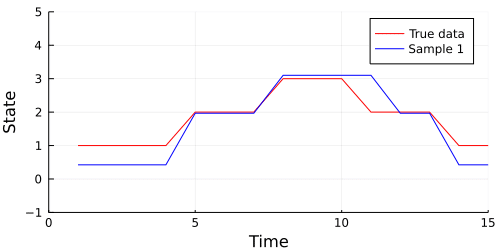

In [77]:
# Import StatsPlots for animating purposes.
using StatsPlots

# Extract our m and s parameters from the chain.
m_set = zeros(length(c), K)
for i in 1:K
    m_set[:, i] = c[Symbol("m[$i]")].data
end
s_set = zeros(length(c), N)
for i in 1:N
    s_set[:, i] = c[Symbol("s[$i]")].data
end

# Iterate through the MCMC samples.
Ns = 1:length(c)

# Make an animation.
animation = @gif for i in Ns
    m = m_set[i, :]; 
    s = Int.(s_set[i,:]);
    emissions = collect(skipmissing(m[s]))
    
    p = plot(y, c = :red,
        size = (500, 250),
        xlabel = "Time",
        ylabel = "State",
        legend = :topright, label = "True data",
        xlim = (0,15),
        ylim = (-1,5));
    plot!(emissions, color = :blue, label = "Sample $i")
end every 10;
animation

Looks like our model did a pretty good job, but we should also check to make sure our chain converges. A quick check is to examine whether the diagonal (representing the probability of remaining in the current state) of the transition matrix appears to be stationary. The code below extracts the diagonal and shows a traceplot of each persistence probability.

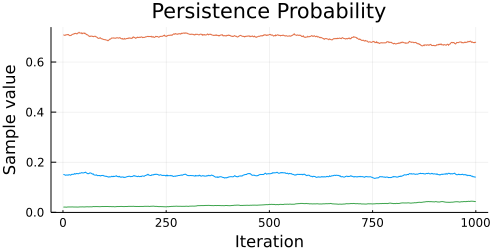

In [81]:
# Index the chain with the persistence probabilities.
subchain = c[:,["T[$i][$i]" for i in 1:K],:]

# Plot the chain.
plot(subchain, 
    colordim = :parameter, 
    seriestype=:traceplot,
    title = "Persistence Probability",
    label = missing,
    legend=:right
    )

A cursory examination of the traceplot above indicates that at least `T[3,3]` and possibly `T[2,2]` have converged to something resembling stationary. `T[1,1]`, on the other hand, has a slight "wobble", and seems less consistent than the others. We can use the diagnostic functions provided by [MCMCChain](https://github.com/TuringLang/MCMCChain.jl) to engage in some formal tests, like the Heidelberg and Welch diagnostic:

In [82]:
for i in 1:3
    println(heideldiag(vec(c[Symbol("T[$i][$i]")].data)))
end

[0.0, 1.0, 0.9690639562331899, 0.14734574390524105, 0.0027980453691647087, 1.0]
[0.0, 1.0, 0.07055461865422319, 0.6951954425405298, 0.013625771752893217, 1.0]
[500.0, 0.0, 0.03810707572946015, 0.035014417459699555, 0.0046476369013698825, 0.0]


The p-values on the test suggest that we cannot reject the hypothesis that the observed sequence comes from a stationary distribution, so we can be somewhat more confident that our transition matrix has converged to something reasonable.